# Mask Detection Dataset

## Imoprt Required Libraries

In [4]:
!pip install beautifulsoup
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement beautifulsoup (from versions: 3.2.0, 3.2.1, 3.2.2)
ERROR: No matching distribution found for beautifulsoup
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import opendatasets
import numpy as np
from pathlib import Path
import itertools as it
import cv2
from bs4 import BeautifulSoup as bsp

In [256]:
class DataSet:
    url = 'https://www.kaggle.com/datasets/andrewmvd/face-mask-detection'
    def __init__(self):
        self.path = None
        self.image_dtype = np.dtype([('image', 'u1', (32, 32, 3)), ('label', 'u1')])
        self.images = None
        self.size = 0
    
    def _generate_new_images(self):
        assert self.load_data(self.path, self.url), 'An Error occured while loading dataset'
        path_iter = (Path(self.path) / 'annotations').iterdir()
        for i in path_iter:
            if not i.is_file():
                continue
            with open(i) as f:
                soup = bsp(f.read(), 'xml')
                filename = Path(self.path) / 'images' / soup.find('filename').text
                pic = cv2.imread(str(filename))
                self._construct_new_image(soup, pic, filename)
                        
    def _construct_new_image(self, soup, pic, filename):
        for i in soup('object'):
            if i.find('name').text == 'without_mask':
                label = 0
            if i.find('name').text == 'with_mask':
                label = 1
            else:
                label = 2
            xmin = int(i.find('xmin').text)
            xmax = int(i.find('xmax').text)
            ymin = int(i.find('ymin').text)
            ymax = int(i.find('ymax').text)
            face = cv2.resize(pic[ymin:ymax, xmin:xmax], (32, 32))
            if self.images is None:
                self.images = np.array([(face, label)], dtype=self.image_dtype)
            else:
                self.images = np.append(self.images, np.array([(face, label)], dtype=self.image_dtype))
        self.size = self.images.size
                
    @staticmethod
    def load_data(path, url):
        path = Path(path)
        if not path.is_dir():
            print(path.is_dir())
            try:
                opendatasets.download(url)
                return True
            except BaseException as e:
                raise Load_DataSet_Error(f'An error occured while downloading and creating {path} dir.')
        return True       
    
    @staticmethod
    def save_split_dataset(to_path, *args, **kwargs):
        np.savez_compressed(str(to_path), **kwargs)
        
    def _new_dataset(self, data):
        self.images = data
        self.size = data.size
        self.image_dtype = data.dtype

    def __call__(self, *, data=None, path=None):
        if data is not None:
            self._new_dataset(data)
            return self
        self.path = path
        self._generate_new_images()
    
    def __getietm__(self, index):
        return self.images[index]
    
    @classmethod
    def split_data(cls, images,portion=[.5, .2, .3]):
        assert sum(portion) == 1, 'Sum of portion not equal to 1'
        size = tuple(map(lambda i: int(images.size * i), portion))
        indecies = it.accumulate(size, lambda x,y: x+y)
        return tuple(map(lambda i: cls()(data=i), np.split(images, [*indecies])))[:3]


class Load_DataSet_Error(BaseException):
  pass

In [257]:
face_dataset = DataSet()
face_dataset(path='face-mask-detection')

## Split Data and Create New Dataset

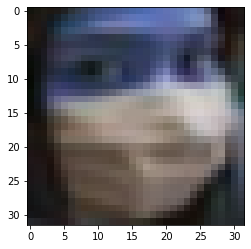

In [262]:
plt.imshow(face_dataset.images['image'][40])

In [263]:
train, validation, test = DataSet.split_data(face_dataset.images)
DataSet.save_split_dataset('splited_dataset.npz', train=train.images, validation=validation.images, test=test.images)

> now `splited_dataset.npz` file has 40 M size. this very better than 500 M

In [264]:
data = np.load('splited_dataset.npz')

In [265]:
train = data['train']
validation = data['validation']
test = data['test']

## Model

In [266]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Config GPU Processing

In [267]:
pysical_devices = tf.config.experimental.list_physical_devices("GPU")
print('Num GPUs Available: ', len(pysical_devices))
tf.config.experimental.set_memory_growth(pysical_devices[0], True)

Num GPUs Available:  1


In [268]:
input = keras.Input(shape=(32*32*3,), name='input')
features = layers.Dense(128, activation='relu',  kernel_regularizer='l2', name='laye_1')(input)
features = layers.Dense(64, activation='relu',  kernel_regularizer='l2', name='layer_2')(features)
features = layers.Dropout(0.2, name='Dropout_layer')(features)
features = layers.Dense(16, activation='relu',  kernel_regularizer='l2', name='layer_3')(features)
output = layers.Dense(3, activation='softmax', name='output')(features)
model = keras.Model(inputs=input, outputs=output, name='mask_detect_1')

In [269]:
model.summary()

Model: "mask_detect_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3072)]            0         
                                                                 
 laye_1 (Dense)              (None, 128)               393344    
                                                                 
 layer_2 (Dense)             (None, 64)                8256      
                                                                 
 Dropout_layer (Dropout)     (None, 64)                0         
                                                                 
 layer_3 (Dense)             (None, 16)                1040      
                                                                 
 output (Dense)              (None, 3)                 51        
                                                                 
Total params: 402,691
Trainable params: 402,691
Non-t

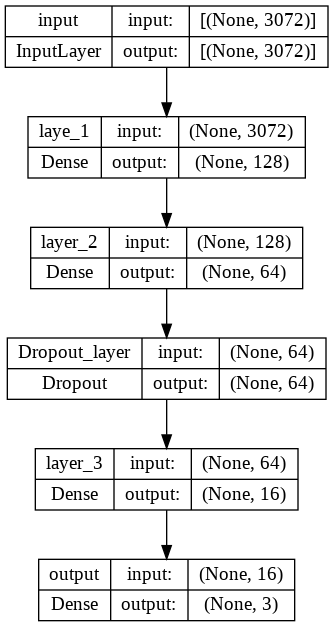

In [270]:
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [271]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [273]:
tf.config.run_functions_eagerly(True)
callbacklist = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
    keras.callbacks.ModelCheckpoint(filepath='checkpoint.keras', monitor='val_accuracy')
]
train_data = train['image'].reshape(-1, 32*32*3)
validation_data = validation['image'].reshape(-1, 32*32*3)
test_data = test['image'].reshape(-1, 32*32*3)
history = model.fit(
    train_data,
    train['label'],
    callbacks=callbacklist,
    epochs=33,
    use_multiprocessing=True,
    validation_data=(validation_data, validation['label'])
)

Epoch 1/33
 5/64 [=>............................] - ETA: 1s - loss: 379.2155 - accuracy: 0.3562

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


64/64 [==============================] - 2s 31ms/step - loss: 69.2030 - accuracy: 0.6469 - val_loss: 58.5431 - val_accuracy: 0.7862
Epoch 2/33
64/64 [==============================] - 2s 31ms/step - loss: 17.6821 - accuracy: 0.6989 - val_loss: 3.1329 - val_accuracy: 0.7555
Epoch 3/33
64/64 [==============================] - 2s 31ms/step - loss: 8.3908 - accuracy: 0.7269 - val_loss: 2.3333 - val_accuracy: 0.7862
Epoch 4/33
64/64 [==============================] - 2s 31ms/step - loss: 5.8605 - accuracy: 0.7387 - val_loss: 1.3092 - val_accuracy: 0.8096
Epoch 5/33
64/64 [==============================] - 2s 31ms/step - loss: 3.1114 - accuracy: 0.7078 - val_loss: 0.8967 - val_accuracy: 0.7801
Epoch 6/33
64/64 [==============================] - 2s 31ms/step - loss: 1.6372 - accuracy: 0.7038 - val_loss: 0.9152 - val_accuracy: 0.8206
Epoch 7/33
64/64 [==============================] - 2s 31ms/step - loss: 0.9713 - accuracy: 0.7623 - val_loss: 0.7908 - val_accuracy: 0.7862
Epoch 8/33
64/64 [===

In [274]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plot Accuracy vs Validation

In [275]:
import matplotlib.pyplot as plt

In [276]:
def plot_metric(*args, **kwargs):
  loss, val_loss,  metric,*_ = args
  epochs = range(1, len(loss)+1)
  plt.clf()
  plt.plot(epochs, loss, 'r', label=f"train {metric}")
  plt.plot(epochs, val_loss, 'b', label=f"validation {metric}")
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.show()

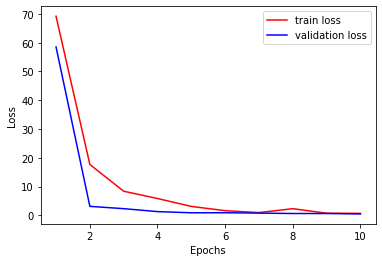

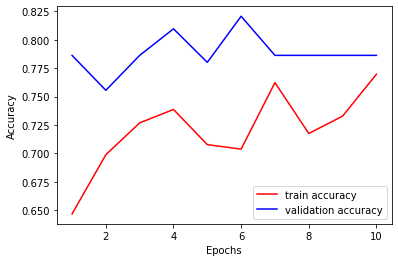

In [277]:
plot_metric(history.history['loss'], history.history['val_loss'], 'loss')
plot_metric(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

## Evalute Generalization

In [278]:
results = model.evaluate(test_data, test['label'])

39/39 [==============================] - 0s 11ms/step - loss: 0.4295 - accuracy: 0.8321


In [279]:
results

[0.42954152822494507, 0.8321048617362976]

## Save Model

In [280]:
model.save('model.h5')
del model

## Load and Predict

In [281]:
model = keras.models.load_model('model.h5')

In [282]:
test_image = test['image'][0]

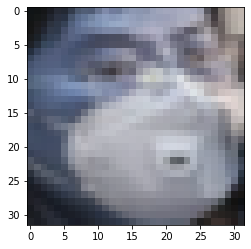

In [283]:
plt.imshow(test_image)

In [292]:
result = model.predict(np.array([test_image.flatten()]))

1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1

In [294]:
def category(pred):
  categories = ('Without Mask', 'With Mask', 'Mask Not Wear')
  return categories[pred]

In [295]:
category(result.argmax())

'With Mask'